In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if('.csv' in (os.path.join(dirname, filename))):
            imdb_data =  pd.read_csv(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/myscript-py/train_model.png
/kaggle/input/myscript-py/NMT_Mtokenizer_wordwise.pkl
/kaggle/input/myscript-py/NMT_model_weight.h5
/kaggle/input/myscript-py/NMT_model.json
/kaggle/input/myscript-py/__results__.html
/kaggle/input/myscript-py/__notebook__.ipynb
/kaggle/input/myscript-py/NMT_data_wordwise.pkl
/kaggle/input/myscript-py/__output__.json
/kaggle/input/myscript-py/NMT_Etokenizer_wordwise.pkl
/kaggle/input/myscript-py/custom.css
/kaggle/input/myscript-py/__results___files/__results___54_0.png
/kaggle/input/myscript-py/__results___files/__results___49_0.png
/kaggle/input/imdb-noiseddata/IMDB_denoisedData.csv


In [114]:
imdb_data.columns

Index(['Unnamed: 0', 'review', 'char_augumented', 'keyborad_augumented', 'random_augumented', 'substitute_augumented', 'swap_augumented', 'delete_augumented', 'spell_augumented', 'Synonym_augumented', 'swapWord_augumented'], dtype='object')

In [115]:
imdb_dataset_v1 = imdb_data[['random_augumented','review']]
imdb_dataset_v1 = imdb_dataset_v1.rename(columns={"review": "solution", "random_augumented": "original"}, errors="raise")
imdb_dataset_v1['original'] = imdb_dataset_v1['original'].map(lambda x: x.replace('<br /> <br />',""))
imdb_dataset_v1['solution'] = imdb_dataset_v1['solution'].map(lambda x: x.replace('<br /><br />',""))
train_df = imdb_dataset_v1[:10000]
print (train_df.original.apply(lambda x: len(x.split())).describe())

count    10000.000000
mean     248.403600  
std      184.318643  
min      14.000000   
25%      135.000000  
50%      185.000000  
75%      303.000000  
max      1959.000000 
Name: original, dtype: float64


In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

In [117]:
!pip install bpemb
import bpemb
from bpemb import BPEmb
import random
import os
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
bpemb_en = BPEmb(lang="en", dim=50)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [118]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [119]:
# train_input = pd.read_csv('../input/correct-ocr-errors/train_input.csv',encoding='utf-8')
# train_output = pd.read_csv('../input/correct-ocr-errors/train_output.csv', encoding = 'utf-8')

In [120]:
# print (train_input.shape, train_output.shape)
# print (train_input.columns, train_output.columns)

In [121]:
# if(train_input.shape == train_output.shape):
#     train_df = train_input.merge(train_output, left_on='id', right_on='id')
# pd.isnull(train_df).sum()

In [122]:
train_df = train_df[~pd.isnull(train_df['original'])]
train_df.drop_duplicates(inplace=True)
print (train_df.shape)
print (train_df.columns)

(10000, 2)
Index(['original', 'solution'], dtype='object')


In [123]:
#Lowercase all the character
train_df['original']=train_df['original'].apply(lambda x: x.lower())
train_df['solution']=train_df['solution'].apply(lambda x: x.lower())

In [124]:
#Remove all the quotes
train_df['original']=train_df['original'].apply(lambda x: re.sub("'", '', x))
train_df['solution']=train_df['solution'].apply(lambda x: re.sub("'", '', x))

In [125]:
#Remove all the special character 
exclude = set(string.punctuation) # Set of all special characters
train_df['original']=train_df['original'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
train_df['solution']=train_df['solution'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [126]:
#Remove all numbers from the text 
remove_digits = str.maketrans('', '', digits)
train_df['original']=train_df['original'].apply(lambda x:  x.translate(remove_digits))
train_df['solution']=train_df['solution'].apply(lambda x:  x.translate(remove_digits))
train_df['solution']=train_df['solution'].apply(lambda x:  re.sub("[२३०८१५७९४६]", "", x))

In [127]:
#Remove extra spaces 
train_df['original']=train_df['original'].apply(lambda x: x.strip())
train_df['solution']=train_df['solution'].apply(lambda x:  x.strip())
train_df['original']=train_df['original'].apply(lambda x: re.sub(" +", " ", x))
train_df['solution']=train_df['solution'].apply(lambda x:  re.sub(" +", " ", x))

In [128]:
# #Use bpemb tokenization 
# train_df['original']=train_df['original'].apply(lambda x: ' '.join(bpemb_en.encode(x)))
# train_df['solution']=train_df['solution'].apply(lambda x:  ' '.join(bpemb_en.encode(x)))

In [129]:
# Add start and end tokens to target sequences
train_df['solution']=train_df['solution'].apply(lambda x:  'START_ '+ x + ' _END')

In [130]:
print (train_df.head(1))
print (type(train_df['original']))

In [131]:
train_df['length_of_original_sent']=train_df['original'].apply(lambda x: len(x.split(" ")))
train_df['length_of_solution_sent']=train_df['solution'].apply(lambda x: len(x.split(" ")))

In [132]:
train_df = train_df[train_df['length_of_original_sent']<500]
train_df = train_df[train_df['length_of_solution_sent']<500]
train_df.shape

(9171, 4)

In [133]:
X = train_df['original']
Y = train_df['solution']

In [134]:
print(X.shape)
print (type(X))

(9171,)
<class 'pandas.core.series.Series'>


In [135]:
import collections
from collections import Counter
vocab = Counter()
for doc in X:
    vocab.update(doc.split()) 
for doc in Y:
    vocab.update(doc.split())
len(vocab),type(vocab)

(124030, collections.Counter)

In [136]:
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

52414


In [137]:
word2index = {}
index2word = {}
word2index['unknown'] = 0
len(index2word),len(word2index)
for token in tokens:
    word2index[token] = len(word2index)

In [138]:
print (len(word2index))
for word,index in word2index.items():
    index2word[int(index)] = word

52414


In [139]:
len(index2word)

52413

In [140]:
def ConvertWord2Index(series):
    for ind, val in series.items():
        val = val.split()
        toke=[]
        for valtok in val:
            if valtok in word2index.keys():
                toke.append(word2index[valtok])
            else:
                toke.append(word2index['unknown'])
        series[ind] = toke
    return series

In [141]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7336,), (1835,), (7336,), (1835,))

In [142]:
print (type(X_train))
y_train[0]

<class 'pandas.core.series.Series'>


'START_ one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty p

In [143]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_solution = (Max_length(X_train))
max_length_original = Max_length(y_train)+1
#Test data
max_length_solution_test = Max_length(X_test)
max_length_original_test = Max_length(y_test)
max_length_solution, max_length_original

(499, 497)

In [144]:
max_length_solution = max(max_length_solution, max_length_original)
max_length_original = max_length_solution
max_length_solution, max_length_original

(499, 499)

In [145]:
X_train = ConvertWord2Index(X_train)
X_test = ConvertWord2Index(X_test)
y_train = ConvertWord2Index(y_train)
y_test = ConvertWord2Index(y_test)

In [146]:
print (type(X_train))
X_train[0]

<class 'pandas.core.series.Series'>


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 3,
 29,
 30,
 8,
 31,
 28,
 32,
 12,
 33,
 34,
 35,
 36,
 37,
 38,
 2,
 39,
 40,
 41,
 42,
 20,
 43,
 3,
 44,
 45,
 46,
 28,
 22,
 23,
 47,
 48,
 49,
 50,
 3,
 51,
 52,
 53,
 54,
 22,
 49,
 55,
 56,
 57,
 27,
 58,
 59,
 60,
 61,
 53,
 39,
 34,
 23,
 62,
 42,
 3,
 63,
 64,
 2,
 3,
 44,
 65,
 23,
 66,
 12,
 21,
 67,
 23,
 3,
 68,
 6354,
 59,
 3,
 69,
 70,
 71,
 72,
 73,
 65,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 2,
 3,
 82,
 83,
 84,
 3,
 85,
 86,
 87,
 88,
 36,
 89,
 90,
 91,
 92,
 23,
 47,
 93,
 76,
 3,
 94,
 95,
 78,
 23,
 96,
 59,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 36,
 105,
 91,
 106,
 107,
 108,
 109,
 6354,
 36,
 110,
 111,
 19,
 112,
 113,
 114,
 115,
 116,
 117,
 3,
 118,
 119,
 2,
 3,
 49,
 23,
 120,
 59,
 3,
 121,
 8,
 65,
 122,
 83,
 4,
 123,
 124,
 125,
 6354,
 126,
 127,
 128,
 129,
 50,
 130,
 131,
 126,
 132,
 126,
 133,
 12,
 1

In [147]:
X_train = pad_sequences(X_train, maxlen = max_length_solution, padding='post')
X_test = pad_sequences(X_test, maxlen = max_length_solution, padding='post')
y_train = pad_sequences(y_train, maxlen = max_length_solution, padding='post')
y_test = pad_sequences(y_test, maxlen = max_length_solution, padding='post')

In [148]:
print (type(X_train))
X_train[0]

<class 'numpy.ndarray'>


array([  115,  1412,    22,   346,    91, 37019,   115,  6354,    65,
        1274,    65,    23,    47, 31294,   574,   546,   346, 15135,
        7621,    76,  8026,    61,   677,    36,  7323,   725,   895,
          47,  2484,     3,   384,    65,  6755,    59,   357,    65,
          42,     3,    29,  1737,  2193,  3884,  3885,  5821,    48,
       38560,     2, 27195,  7980,    84,   115,   955,  6354,    33,
         211,  4952,    65,    50,  6354,   603,    48,   583,   346,
         808,   125, 31988,   183,   195,    53,   384,    76,    22,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [149]:
X_train.shape

(7336, 499)

In [150]:
vocab_size_source = len(word2index)
vocab_size_target = len(word2index)

In [151]:
vocab_size_target

52414

In [152]:
'''originalTokenizer = Tokenizer()
print (originalTokenizer)
originalTokenizer.fit_on_texts(X_train)
print ('\n',originalTokenizer,'\nhere we have',type(originalTokenizer))
Oword2index = originalTokenizer.word_index
print(len(Oword2index))
vocab_size_source = len(Oword2index) + 1
X_train[0]
X_train = originalTokenizer.texts_to_sequences(X_train)
print (type(X_train[0]),'\n',X_train[0])
X_train = pad_sequences(X_train, maxlen=max_length_original, padding='post')
X_test = originalTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_original, padding='post')
solutionTokenizer = Tokenizer()
solutionTokenizer.fit_on_texts(y_train)
Sword2index = solutionTokenizer.word_index
vocab_size_target = len(Sword2index) + 1
y_train = solutionTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_solution, padding='post')
y_test = solutionTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_solution, padding='post')
vocab_size_source, vocab_size_target'''

"originalTokenizer = Tokenizer()\nprint (originalTokenizer)\noriginalTokenizer.fit_on_texts(X_train)\nprint ('\n',originalTokenizer,'\nhere we have',type(originalTokenizer))\nOword2index = originalTokenizer.word_index\nprint(len(Oword2index))\nvocab_size_source = len(Oword2index) + 1\nX_train[0]\nX_train = originalTokenizer.texts_to_sequences(X_train)\nprint (type(X_train[0]),'\n',X_train[0])\nX_train = pad_sequences(X_train, maxlen=max_length_original, padding='post')\nX_test = originalTokenizer.texts_to_sequences(X_test)\nX_test = pad_sequences(X_test, maxlen = max_length_original, padding='post')\nsolutionTokenizer = Tokenizer()\nsolutionTokenizer.fit_on_texts(y_train)\nSword2index = solutionTokenizer.word_index\nvocab_size_target = len(Sword2index) + 1\ny_train = solutionTokenizer.texts_to_sequences(y_train)\ny_train = pad_sequences(y_train, maxlen=max_length_solution, padding='post')\ny_test = solutionTokenizer.texts_to_sequences(y_test)\ny_test = pad_sequences(y_test, maxlen = ma

In [153]:
print (type(X_train))

<class 'numpy.ndarray'>


In [154]:
X_train.shape

(7336, 499)

In [155]:
with open('NMT_data_wordwise.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f,protocol=pkl.HIGHEST_PROTOCOL)
with open('NMT_Etokenizer_wordwise.pkl','wb') as f:
  pkl.dump([vocab_size_source, word2index], f, protocol=pkl.HIGHEST_PROTOCOL)
with open('NMT_Mtokenizer_wordwise.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, index2word], f,protocol=pkl.HIGHEST_PROTOCOL)
filename = os.path.join('./utility_data','NMT_Etokenizer.pkl')
#with open(filename, 'rb') as f:
    #data_solution = pkl.load(f)
    #solutionTokenizer = Tokenizer()
    #vocab_size_source, Sword2index, solutionTokenizer  = data_solution
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [156]:
# import pickle as pkl
# filename ='../input/nmtdata/NMT_data.pkl'
# with open(filename, 'rb') as f:
#     data = pkl.load(f)
#     X_train, y_train, X_test, y_test = data
#     print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# print (X_train.shape, y_train.shape, X_test.shape,type(X_test))
# Tok_filename ='../input/nmtdata/NMT_Etokenizer.pkl'
# with open(Tok_filename, 'rb') as f:
#     data = pkl.load(f)
#     vocab_size_source, word2index = data
# print ((vocab_size_source),len(word2index))
# Tok_filename ='../input/nmtdata/NMT_Mtokenizer.pkl'
# with open(Tok_filename, 'rb') as f:
#     data = pkl.load(f)
#     vocab_size_target, index2word = data
# print ((vocab_size_target),(index2word[0]))

In [46]:
import attention
from attention import AttentionLayer
from keras import backend as K 
K.clear_session() 
latent_dim = 200
# Encoder 
encoder_inputs = Input(shape=(max_length_original,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [47]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

In [48]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

In [49]:
# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input)

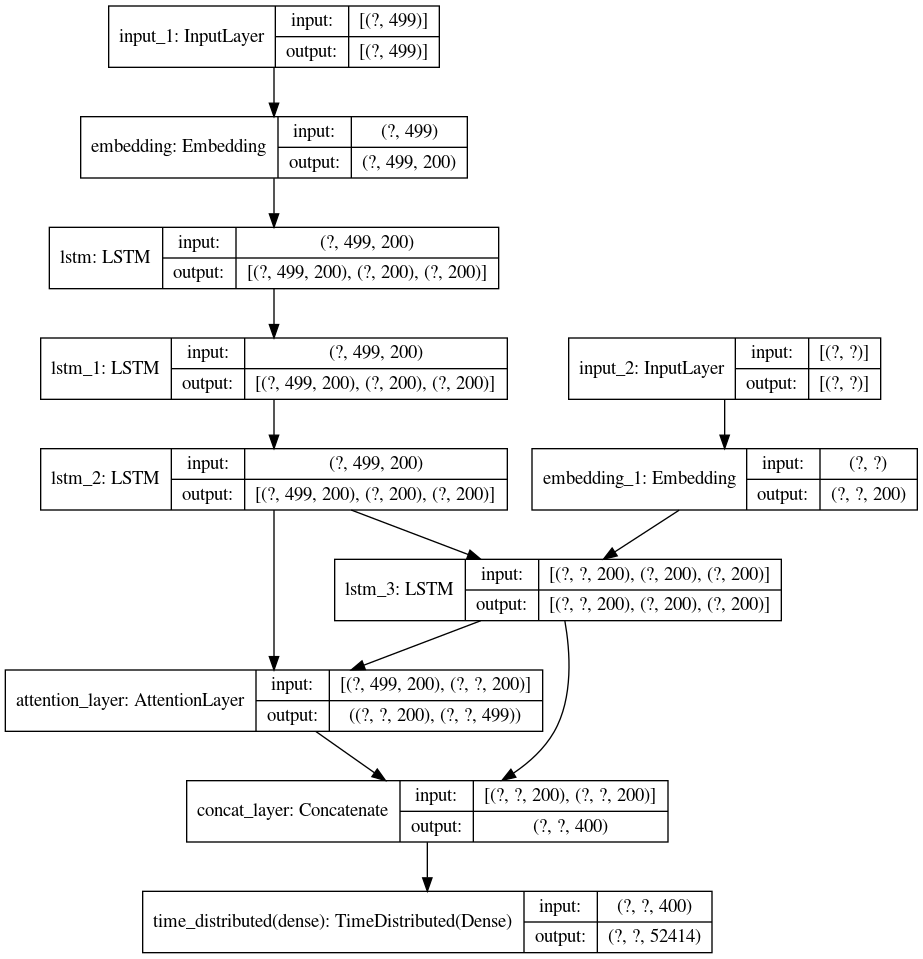

In [50]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
plot_model(model, to_file='train_model.png', show_shapes=True)

In [51]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 499)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 499, 200)     10482800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 499, 200), ( 320800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=10, 
                    callbacks=[es],
                    batch_size=20,
                    validation_data = ([X_test, y_test[:,:-1]],           y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
#Model saving and loadin 
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

In [157]:
# loading the model architecture and asigning the weights
#json_file = open('NMT_model.json', 'r')
json_file = open('/kaggle/input/myscript-py/NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
#model_loaded.load_weights("NMT_model_weight.h5")
model_loaded.load_weights('/kaggle/input/myscript-py/NMT_model_weight.h5')

In [158]:
# latent_dim=200
# # encoder inference
# encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
# encoder_outputs, state_h, state_c = model.layers[6].output #loading encoder_outputs
# #print(encoder_outputs.shape)
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# # decoder inference
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_hidden_state_input = Input(shape=(32,latent_dim))
# # Get the embeddings of the decoder sequence
# decoder_inputs = model_loaded.layers[3].output
# #print(decoder_inputs.shape)
# dec_emb_layer = model_loaded.layers[5]
# dec_emb2= dec_emb_layer(decoder_inputs)
# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_lstm = model_loaded.layers[7]
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
# #attention inference
# attn_layer = model_loaded.layers[8]
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# concate = model_loaded.layers[9]
# decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# # A dense softmax layer to generate prob dist. over the target vocabulary
# decoder_dense = model_loaded.layers[10]
# decoder_outputs2 = decoder_dense(decoder_inf_concat)
# # Final decoder model
# decoder_model = Model(
# [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
# [decoder_outputs2] + [state_h2, state_c2])

In [159]:
latent_dim=200
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [160]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
# Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
# Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = word2index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = index2word[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
# Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (600-1)):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [161]:
#Sindex2word = solutionTokenizer.index_word
#Oindex2word = originalTokenizer.index_word

In [162]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=word2index['START_']) and i!=word2index['_END']):
        newString=newString+index2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+index2word[i]+' '
    return newString

In [163]:
train_df.columns

Index(['original', 'solution', 'length_of_original_sent', 'length_of_solution_sent'], dtype='object')

In [167]:
textfile ={}
textfile['original'] =[]
textfile['solution'] =[]
textfile['predicted_text'] =[]
for i in range(400):
    print (i)
    textfile['original'].append(seq2text(X_test[i]))
    textfile['solution'].append(seq2text(y_test[i]))
    textfile['predicted_text'].append(decode_sequence(X_test[i].reshape(1,max_length_solution)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [168]:
print(textfile.keys())

dict_keys(['original', 'solution', 'predicted_text'])


In [169]:
import numpy as np
import  nltk.translate.bleu_score as bleu

In [170]:
def WRR(text1,text2):
    a = set(text1.lower().split())
    b = set(text2.lower().split())
    
    if (len(a) == 0) and (len(b) == 0):
        return .5
    
    c = a.intersection(b)
    return float(len(c))/(len(a) + len(b) - len(c))

def levenshtein(seq1, seq2):
    seq1 = seq1.lower()
    seq2 = seq2.lower()
    
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

def CRR(text1, text2):
    try:
        return 1 - float(levenshtein(text1,text2))/max(len(text1),len(text2))
    except:
        return 0

def bleu_score(text1,text2):
    return bleu.sentence_bleu([text1.lower().split()],text2.lower().split())

In [171]:
df = pd.DataFrame.from_dict(textfile)

In [173]:
df.head()

,original,solution,predicted_text
0,the outsiders is undoubtedly a solidified solidified tv series well defined characters tight scripts varied and interesting solidified great guest solidified and a filmic ambiance all combined to make this vseries a special one sadly andrew keir has passed on sascha hehn from germany does not appear unfortunately to have enjoyed small solidified success in his native country the abc has repeated the series many times yet a dvd release is yet to happen the series is one which is timeless it is as likely to strike a solidified solidified witoh viewers today as it did in its own day come on abc solidified the outsiders on dvd,START_ the outsiders is undoubtedly a classic australian tv series well defined characters tight scripts varied and interesting locales great guest stars and a filmic ambiance all combined to make this series a special solidified andrew keir has passed on sascha hehn from germany does not appear unfortunately to have enjoyed small screen success in his native country the abc has repeated the series many times yet a dvd release is yet to happenthe series is one which is timeless it is as likely to strike a resonant chord with viewers today as it did in its own day come on solidified the outsiders on dvd _END,the most is an interesting idea for one episode well with all kinds of humor from solidified not even close to have seen in his solidified from one of his early s the time has the best time and a must have seen his first of solidified in his early s solidified in his early s solidified in his early s solidified in his early s the time has the best time yet a documentary which is as to solidified the series is one is great it as to anyone to a solidified or solidified for it and on tv on tv solidified the tv on dvd _END
1,first of all i solidified the casting and acting were excellent the problem is the story there is solidified no story here worth telling and thus basically no movice here larry mcmurtry has done lonesome dove and i can t fault the original though it solidified didn t need sequels he did hud with paul newman which is one of my favorite movies mellencamp is supposed to be a country singer but the only song i hear him sing is an old buck owens song the movie makes a big deal out of chicken farming mellencamp s character has a good wife and it s utterly stupid of him to stray from her the solidified wipth riding in the sliding cage is utterly stupid maybe people do that for fun in some parts of the country but i never heard of it,START_ first of all i think the casting and acting were excellent the problem is the story there is basically no story here worth telling and thus basically no movie here larry mcmurtry has done lonesome dove and i cant fault the original though it probably didnt need sequels he did hud with paul newman which is one of my favorite movies mellencamp is supposed to be a country singer but the only song i hear him sing is an old buck owens song the movie makes a big deal out of chicken farming solidified character has a good wife and its utterly stupid of him to stray from her the incident with riding in the sliding cage is utterly stupid maybe people do that for fun in some parts of the country but i never heard of it _END,first of all i thought the other actors and acting was the story there is no real story to do and no no matter its hard to be a real solidified but what can be the best one ever solidified that would expect him he did he did with his job as well be the greatest thing that i liked him is an old man with that the movie is a big fun out of solidified solidified are not a good example of solidified solidified are being a good and solidified of them to help their the solidified solidified of the solidified is just plain stupid how can for for the action movies of the other things i would like of it _END
2,why do the powers that be continue to cast jennifer lopez in unbelievable roles she was excellent in selena and pret

In [178]:
df.columns

Index(['original', 'solution', 'predicted_text'], dtype='object')

In [174]:
df.solution = df.solution.str.replace('START_','')
df.solution = df.solution.str.replace('_END','')
df.predicted_text = df.predicted_text.str.replace('START_','')
df.predicted_text = df.predicted_text.str.replace('_END','')


In [188]:
# result={1:[],2:[],3:[],4:[]}
# for row, data in df.iterrows():
#     originaltxt = data['original']
#     soltxt = data['solution']
#     predtxt = data['predicted_text']
#     #print(len(originaltxt))
#     result[1].append(WRR(originaltxt, soltxt))
#     result[2].append(WRR(predtxt, soltxt))
#     result[3].append(bleu_score(originaltxt, soltxt))
#     result[4].append(bleu_score(predtxt, soltxt))
    
    

In [189]:
len(result[1])

400

In [ ]:
df['WRR_1'] = df.apply(lambda x: WRR((x.original, x.solution), axis=1))
df['WRR_2'] = df.apply(lambda x: WRR((x.predicted_text, x.solution), axis=1))
                     

In [ ]:
df['BLEU_1'] = df.apply(lambda x: bleu_score((x.original, x.solution), axis=1))
df['BLEU_2'] = df.apply(lambda x: bleu_score((x.predicted_text, x.solution), axis=1))

In [ ]:
df[['WRR_1', 'WRR_2', 'BLEU_1', 'BLEU_2']].describe()

In [ ]:


# with open('outputfile_token.txt','w') as w:
#     for i in range(50):
#         print ("\nProcessing file", i)
#         w.write('%s\t%s\t%s'%(seq2text(X_test[i]),seq2text(y_test[i]),decode_sequence(X_test[i].reshape(1,600))))
#         w.write('\n')
#         #print (X_test[i],"\n",y_test[i])
#   #print("Review:",seq2text(X_test[i]))
#   #print("Original summary:",seq2text(y_test[i]))
#   #print("Predicted summary:",decode_sequence(X_test[i].reshape(1,600)))
#   #print("\n")

In [ ]:
# for i in range(50):    
#   print("Review:",seq2text(X_test[i]))
#   print("Original summary:",seq2text(y_test[i]))
#   print("Predicted summary:",decode_sequence(X_test[i].reshape(1,600)))
#   print("\n")

In [ ]:
# test_input_data = pd.read_csv('../input/correct-ocr-errors/test_input.csv',encoding='utf-8')

In [ ]:
# test_input_data.shape, test_input_data.columns

In [ ]:
#test_input.size, test_input.columns

In [ ]:
# pd.isnull(test_input_data).sum()
# test_input_data = test_input_data[~pd.isnull(test_input_data['original'])]
# test_input_data.drop_duplicates(inplace=True)

In [ ]:
# test_input_data['original']=test_input_data['original'].apply(lambda x: x.lower())
# #Remove all the quotes
# test_input_data['original']=test_input_data['original'].apply(lambda x: re.sub("'", '', x))
# #Remove all the special character 
# exclude = set(string.punctuation) # Set of all special characters
# test_input_data['original']=test_input_data['original'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
# #Remove all numbers from the text 
# remove_digits = str.maketrans('', '', digits)
# test_input_data['original']=test_input_data['original'].apply(lambda x:  x.translate(remove_digits))
# #Remove extra spaces 
# test_input_data['original']=test_input_data['original'].apply(lambda x: x.strip())
# test_input_data['original']=test_input_data['original'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# #Use bpemb tokenization 
# test_input_data['original']=test_input_data['original'].apply(lambda x: ' '.join(bpemb_en.encode(x)))

In [ ]:
# test_input_data.head(1)

In [ ]:
# test_input_data.columns

In [ ]:
# X_test_val = test_input_data['original']

In [ ]:
# print (type(X_test_val),type(test_input_data))

In [ ]:
# X_test_val.shape

In [ ]:
# type(X_test_val[0])

In [ ]:
# Max_length(X_test_val)

In [ ]:
# X_test_val = ConvertWord2Index(X_test_val)

In [ ]:
# X_test_val = pad_sequences(X_test_val, maxlen = max_length_solution, padding='post')

In [ ]:
# X_test_val.shape[0]

In [ ]:
# actual_txt = []
# predicted_txt = []

In [ ]:
# for i in range(X_test_val.shape[0]):  
#     print ("\nProcessing doc number ",i)
#   #print("Review:",seq2text(X_test_val[i]))
#     actual_txt.append(seq2text(X_test_val[i]))
#   #print("Original summary:",seq2summary(y_test[i]))
#   #print("Predicted summary:",decode_sequence(X_test_val[i].reshape(1,600)))
#     predicted_txt.append(decode_sequence(X_test_val[i].reshape(1,600)))
#     print("\n")

In [ ]:
# input_text = []
# actual_text = []
# predicted_text = []
# for i in range(50):
#     print ("\nProcessing doc number ",i)
#     #print("Review:",seq2text(X_test[i]))
#     input_text.append(seq2text(X_test[i]))
#     actual_text.append(seq2text(y_test[i]))
#     predicted_text.append(decode_sequence(X_test[i].reshape(1,600)))
  

In [ ]:
# dict = {'Input Text': input_text, 'Correct Text': actual_text, 'Predicted Text': predicted_text} 

In [ ]:
# df = pd.DataFrame(dict)

In [192]:
df_new.to_csv('predicted_file_result.csv')

In [194]:
df_new.to_csv('predicted_file1_result.csv',sep='\t')